Réalisé par:
<ul>
<li>Anja Ammar</li>
<li>Ala mani</li>
<li>Ghofrane chenenaoui</li>
<li>Hajer mahjoub</li>
<li>Nihel Haddad</li>
<li>Semy kammoun</li>
<li>Zied Sbabti</li>
</ul>

<center><h2>Community Management Topic Modeling & LDA</h2></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import datetime
import locale
import re

import gensim
from gensim.utils import simple_preprocess 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore
import nltk 

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h2><span style="color: green;">1 : Etape Collecter les données</span><h2>

In [3]:
trustpilot = pd.read_csv('trustpilot.csv', index_col=0)
anja = pd.read_csv('anja1.csv', names=['Text','Review','Date'],header=0)
semy = pd.read_csv('semy.csv', names=['Text','Review','Date'],header=0)

In [4]:
anja.head(1)

Text  Review         Date
0  BonjourJe viens plaider la cause des salariés ...       2   13/03/2020

In [5]:
trustpilot.head(1)

Date                                               Text  Review
0  2020-04-02  Les McDonald's en France sont pour la…\nLes Mc...       4

In [6]:
semy.head(1)

Text  Review        Date
0  La plus belle avenue du monde peut être, le pi...       1  2020-02-24

In [7]:
final = pd.concat([trustpilot, semy, anja], axis= 0, sort=False)

In [8]:
final.head(1)

Date                                               Text  Review
0  2020-04-02  Les McDonald's en France sont pour la…\nLes Mc...       4

In [9]:
final['Review'].unique()

array([4, 1, 3, 2, 5], dtype=int64)

In [10]:
GroupReview=final.groupby(["Review"]).count()
GroupReview.sort_values('Review',ascending=False).head()
GroupReview = GroupReview['Date']

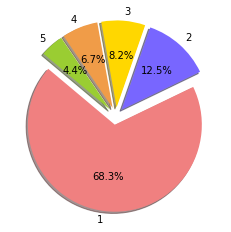

In [11]:
labels = '1', '2', '3','4','5'
explode = (0.1, 0.1, 0.1, 0.1, 0.1) 
#colors
colors = ['lightcoral','#7866ff','gold','#f09c48','yellowgreen']
# Plot
plt.pie(GroupReview,colors=colors, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

<h2><span style="color: green;">2- Prétraiter des données</span><h2>

#### Tokenization: 
<ul>
    <li>diviser le texte en phrases, et les phrases en mots </li>
    <li>transformer les mots en minuscules et enlever la ponctuation</li>
    <li>Enlever les stopwords</li>
    <li>Appliquer la lemmatisation et le stemming</li>
</ul>

In [12]:
stem = SnowballStemmer('french')
sp =stopwords.words('french')

def tokenize_text(text):
    return simple_preprocess(text)

def stemm_text (text):
    return stem.stem(text)
    
def process(text):
    results = []
    for word in tokenize_text(text.lower()):
        if word not in sp :  
            results.append(stemm_text(word))
    return results        

In [13]:
final.Text = final.Text.apply(lambda x: process(x))

<h2><span style="color: green;">4- Enregistrer le texte après les éventuelles transformations </span><h2>

In [14]:
processed_docs = final.copy()
processed_docs.head(3)

Date                                               Text  Review
0  2020-04-02  [mcdonald, franc, mcdonald, franc, plupart, tr...       4
1  2020-03-18  [respons, mc, do, hautain, bonjour, rendu, mc,...       1
2  2020-03-16  [coron, virus, coron, virus, macdonald, met, v...       1

<h2><span style="color: green;">5- BOW sur le jeu de données:</span></h2>

créer un dictionnaire à partir de « processed_docs » contenant le nombre de fois qu’un mot apparaît dans le jeu de données qui servira pour
l’apprentissage.
<br>
Filtrer les tokens qui apparaissent dans:
    <ul>
    <li>Moins de 15 documents (nombre absolu)</li>
    <li>Ne garder que les 100 000 premiers tokens les plus fréquents</li>
    </ul>

In [15]:
dictionnaire = Dictionary(processed_docs.Text)

In [16]:
dictionnaire.filter_extremes(no_below=15, keep_n=100000)

<h3><span style="color: green;">6- Pour chaque document, créer un dictionnaire indiquant combien de mots et combien
de fois ces mots apparaissent. </span></h3>

In [17]:
etape2 = processed_docs.copy()
etape2.Text= etape2.Text.apply(lambda x:  dictionnaire.doc2bow(x)) 

In [18]:
bow_corpus = [ dictionnaire.doc2bow(e) for e in processed_docs.Text.values ]

<h3><span style="color: green;">7- TF-IDF : créer un modèle TF-IDF à partir de « bow_corpus » en utilisant la fonction
models.TfidfModel</span></h3>

In [19]:
model = TfidfModel(bow_corpus)

In [20]:
tfds_corpus = [model[e] for e in bow_corpus]

In [21]:
etape3 = processed_docs.copy()

In [22]:
etape3.Text = tfds_corpus

In [23]:
etape3.head(2)

Date                                               Text  Review
0  2020-04-02  [(0, 0.27219635899733685), (1, 0.3181279676678...       4
1  2020-03-18  [(10, 0.20790389802262327), (11, 0.19204072059...       1

<h3><span style="color: green;">8- Appliquer une méthode sur le BOW: </span></h3>

In [24]:
lda_model = LdaMulticore(etape2.Text, num_topics=10, id2word= dictionnaire )

<h5> Entraîner le modèle LDA:<br> Pour chaque topic explorer les mots qui y figurent et leur poids relatif</h>

<h3><span style="color: green;">9- Appliquer LDA en utilisant TF-IDF</span></h3>

In [25]:
lda_model_tf = LdaMulticore(etape3.Text, num_topics=10, id2word= dictionnaire )

In [26]:
lda_model.print_topics(5)

[(4,
  '0.037*"do" + 0.031*"mac" + 0.028*"command" + 0.016*"mc" + 0.015*"tabl" + 0.013*"tres" + 0.013*"servic" + 0.013*"plus" + 0.013*"tout" + 0.012*"demand"'),
 (1,
  '0.038*"plus" + 0.028*"nouveau" + 0.019*"gobelet" + 0.018*"tout" + 0.018*"vrai" + 0.017*"command" + 0.015*"boisson" + 0.013*"macdo" + 0.012*"do" + 0.012*"mac"'),
 (6,
  '0.035*"tout" + 0.032*"plus" + 0.019*"mc" + 0.018*"nul" + 0.015*"do" + 0.015*"boisson" + 0.013*"nouveau" + 0.012*"si" + 0.012*"gobelet" + 0.012*"command"'),
 (2,
  '0.027*"restaur" + 0.025*"command" + 0.024*"tres" + 0.022*"attent" + 0.017*"personnel" + 0.017*"plus" + 0.014*"tabl" + 0.014*"mcdo" + 0.014*"fait" + 0.013*"peut"'),
 (8,
  '0.045*"plus" + 0.022*"command" + 0.020*"froid" + 0.015*"tout" + 0.015*"fois" + 0.013*"frit" + 0.013*"do" + 0.012*"temp" + 0.012*"mc" + 0.011*"paill"')]

##### le modèle LDA ci-dessus est construit avec 10 sujets différents où chaque sujet est une combinaison de mots-clés et chaque mot-clé contribue à un certain poids au sujet.<br> Nous pouvons voir les mots clés de chaque sujet et la pondération (importance) de chaque mot clé à l'aide de lda_model.print_topics ()

<h3><span style="color: green;">10- Evaluation de la performance du modèle LDA TF-IDF.</span><h3>

In [27]:
for index, score in sorted(lda_model[bow_corpus[4]], key=lambda x: -1*x[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.966655969619751	 
Topic: 0.039*"couvercl" + 0.026*"plus" + 0.026*"tout" + 0.023*"gobelet" + 0.021*"mc"


<h3><span style="color: green;">11- Test du modèle sur un document non vu.</span><h3>

In [28]:
unseen_document = 'service null'
bow_vector = dictionnaire.doc2bow(process(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.5498703718185425	 Topic: 0.039*"couvercl" + 0.026*"plus" + 0.026*"tout" + 0.023*"gobelet" + 0.021*"mc"
Score: 0.05002274364233017	 Topic: 0.037*"do" + 0.031*"mac" + 0.028*"command" + 0.016*"mc" + 0.015*"tabl"
Score: 0.05001829192042351	 Topic: 0.027*"command" + 0.023*"tres" + 0.021*"sandwich" + 0.016*"donald" + 0.016*"comm"
Score: 0.050017088651657104	 Topic: 0.027*"restaur" + 0.025*"command" + 0.024*"tres" + 0.022*"attent" + 0.017*"personnel"
Score: 0.05001630634069443	 Topic: 0.044*"command" + 0.021*"plus" + 0.016*"fair" + 0.015*"attent" + 0.015*"minut"
Score: 0.050015732645988464	 Topic: 0.038*"plus" + 0.028*"nouveau" + 0.019*"gobelet" + 0.018*"tout" + 0.018*"vrai"
Score: 0.050012681633234024	 Topic: 0.044*"command" + 0.029*"tres" + 0.022*"plus" + 0.018*"do" + 0.017*"born"
Score: 0.05001133680343628	 Topic: 0.035*"tout" + 0.032*"plus" + 0.019*"mc" + 0.018*"nul" + 0.015*"do"
Score: 0.05001121014356613	 Topic: 0.030*"nouveau" + 0.026*"gobelet" + 0.019*"do" + 0.018*"plus" + 0.

In [29]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [30]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, tfds_corpus, dictionnaire, mds='mmds')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.062725  0.005075       1        1  12.680739
5      0.031958 -0.017210       2        1  11.513105
9     -0.060538  0.064903       3        1  11.192681
3      0.070995 -0.031746       4        1  11.022476
0      0.062311  0.015835       5        1  10.491945
8     -0.001697  0.035324       6        1  10.394274
4      0.037857  0.057793       7        1   9.643073
2      0.034419 -0.083487       8        1   8.679121
6     -0.037133  0.018575       9        1   7.349450
7     -0.075447 -0.065061      10        1   7.033131, topic_info=         Term       Freq      Total Category  logprob  loglift
46   couvercl  20.000000  20.000000  Default  30.0000  30.0000
126   nouveau  26.000000  26.000000  Default  29.0000  29.0000
177   gobelet  26.000000  26.000000  Default  28.0000  28.0000
9        tres  33.000000  33.000000  Default  27.0000  27.0000
38       tout  36.000000  36.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
14    command   2.080585  62.216751  Topic10  -4.4516  -0.7434
55      quand   1.410349  15.250095  Topic10  -4.8404   0.2738
35       pass   1.305520  16.602276  Topic10  -4.9177   0.1116
314     champ   1.248103  11.845246  Topic10  -4.9626   0.4042
217      vrai   1.245544  19.924515  Topic10  -4.9647  -0.1178

[571 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
78        1  0.185046  accueil
78        5  0.185046  accueil
78        7  0.185046  accueil
78        8  0.185046  accueil
249       1  0.220992  agréabl
...     ...       ...      ...
261       5  0.149061     être
261       6  0.074530     être
261       7  0.074530     être
261       8  0.149061     être
261       9  0.074530     être

[1420 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 10, 4, 1, 9, 5, 3, 7, 8])

# Objectifs métiers:


- 1/  Évaluer les avis des clients afin d'extraire les points forts,les points faibles,les risques et les opportunités cachées de MC Donald France : 
- 2/ Évaluer la qualité de services/produits du MC Donald France et son évolution au cours du temps
- 3/  Prévenir une situation de crise : problèmes sur un produit/service, maladresse dans les médias, “Bad buzz” médiatique, mécontentement d’une communauté

# Interprétation : 

- D'aprés l'analyse du modéle LDA entrainé , on peut remarquer qu'il y a 3 sujets (topics) dont les commentaires collectés parlent: 

- A cause de la forte présence des termes négatifs tels que 'null' , 'froid' , 'sale' , 'catastroph' , 'attente' ,'temp' etc  , on peut remarquer que la qualité de services du MC Donald France est faible.
- Par contre , Il y a aussi une faible présence des termes positifs ( 'bien' , 'bon' , etc ) qui relféte une satisfaction d'une minorité de  clients par rapport aux services et aux produits.
- De plus , on peut remarquer la  présence moyenne des termes ( 'goblet' , 'frite' , 'nourriture' ,'sac' ,'sandwich ','sauce' , 'boisson'  etc ) qui reflétent beaucoup de reclamations des clients de Mac Do par rapport à quelques services et produits et par conséquent un mécontentement de la communité de Mac Do France.

